<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Zhou_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


mesh.hmax:  0.1271205903301709 , L2 error1 0.1500356116804699
Done!
0.13393944403532804
1.133939444035328
6.287586617812055
8.891990269505387
3.143793308906027
5.445209739520318
3.143793308906027
8.31769526875421


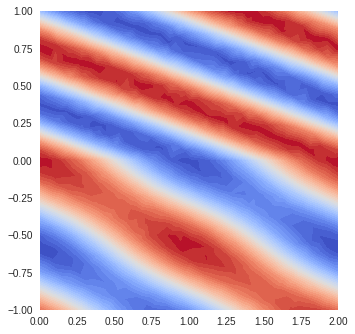

In [0]:
!rm -rf *

from dolfin import *
import sympy as sym
import math
import ufl
from mshr import *


import matplotlib.pyplot as plt

mresolution = 20

# variational form
def F_func(Erx,Ery,Erz,Eix, Eiy,Eiz,Hrx,Hry,Hrz, Hix, Hiy, Hiz,erx, ery, erz,eix, eiy, eiz,hrx, hry, hrz,hix, hiy, hiz,theta):

    F = (inner((Erz.dx(1)-MU*k0*Hix), (erz.dx(1)-MU*k0*hix))*theta*dx ,
     inner((-Erz.dx(0)-MU*k0*Hiy), (-erz.dx(0)-MU*k0*hiy))*theta*dx,
     inner((Ery.dx(0)-Erx.dx(1)-MU*k0*Hiz), (ery.dx(0)-erx.dx(1)-MU*k0*hiz))*theta*dx, #curl(Er)-k0*Hi=0

     inner((Eiz.dx(1)+MU*k0*Hrx),(eiz.dx(1)+MU*k0*hrx))*theta*dx ,
     inner((-Eiz.dx(0)+MU*k0*Hry),(-eiz.dx(0)+MU*k0*hry))*theta*dx ,
     inner((Eiy.dx(0)-Eix.dx(1)+MU*k0*Hrz), (eiy.dx(0)-eix.dx(1)+MU*k0*hrz))*theta*dx, #curl(Ei)+k0*Hr=0

     inner((Hrz.dx(1) + EPS*k0*Eix),(hrz.dx(1) +EPS*k0*eix))*theta*dx ,
     inner((-Hrz.dx(0) + EPS*k0*Eiy),(-hrz.dx(0) +EPS*k0*eiy))*theta*dx ,
     inner((Hry.dx(0)-Hrx.dx(1)+EPS*k0*Eiz),(hry.dx(0)-hrx.dx(1)+EPS*k0*eiz))*theta*dx ,#curl(Hr)+k0*Ei=0

     inner((Hiz.dx(1) - EPS*k0*Erx),(hiz.dx(1) -EPS* k0*erx))*theta*dx ,
     inner((-Hiz.dx(0) - EPS*k0*Ery),(-hiz.dx(0)- EPS*k0*ery))*theta*dx ,
     inner((Hiy.dx(0)-Hix.dx(1)-EPS*k0*Erz),(hiy.dx(0)-hix.dx(1)-EPS*k0*erz))*theta*dx , ##curl(Hi)-k0*Er=0

      EPS*(Erx.dx(0)+Ery.dx(1) )*EPS*(erx.dx(0)+ery.dx(1) )*theta*dx, #   div(Er)*div(er)*dx
      EPS*(Eix.dx(0)+Eiy.dx(1) )*EPS*(eix.dx(0)+eiy.dx(1) )*theta*dx,#     div(Ei)*div(ei)*dx
      MU*(Hrx.dx(0)+Hry.dx(1) )*MU*(hrx.dx(0)+hry.dx(1) )*theta*dx, #   div(Hr)*div(hr)*dx
      MU*(Hix.dx(0)+Hiy.dx(1) )*MU*(hix.dx(0)+hiy.dx(1) )*theta*dx,#     div(Hi)*div(hi)*dx

     (inner((Erz-Erz0_exact),erz)+inner((Eiz-Eiz0_exact),eiz) + inner((Hrx-Hrx0_exact),hrx)+inner((Hix-Hix0_exact),hix)+inner((Hry-Hry0_exact),hry)+inner((Hiy-Hiy0_exact),hiy) )*theta*1.0/h*bot_mk*ds,  (inner(Erx,erx)+inner(Ery,ery)+inner(Eix, eix)+inner(Eiy,eiy)+inner(Hrz,hrz)+inner(Hiz,hiz))*theta*1.0/h*bot_mk*ds,   # Defines solution on bottom boundary

     (inner((Erz-Erz1_exact),erz)+inner((Eiz-Eiz1_exact),eiz) + inner((Hrx-Hrx1_exact),hrx)+inner((Hix-Hix1_exact),hix)+inner((Hry-Hry1_exact),hry)+inner((Hiy-Hiy1_exact),hiy) )*theta*1.0/h*top_mk*ds, (inner(Erx,erx)+inner(Ery,ery)+inner(Eix, eix)+inner(Eiy,eiy)+inner(Hrz,hrz)+inner(Hiz,hiz))*theta*1.0/h*top_mk*ds     # Defines solution on top boundary
      )
    return(F)

## Define free-space permittivity and permeability

mu0 = 4*pi*1e-7
epsilon0 = 8.854*1e-12

## Define relative permittivity and permeability, since this code only tests PBC, the domain has homogeneous properties
mur = [1,2]

# MU = Expression("x[1] <= 0.0 ? mur1 : mur2", mur1=mur1, mur2=mur2, degree=0)

eps = [1,1]
# eps2 = 1
# EPS = Expression("x[1] <= 0.0 ? eps1 : eps2", eps1=eps1, eps2=eps2, degree=0)


E_norm = epsilon0**(.5)
H_norm = mu0**(.5)

freq = 300e6

eta1 = (mu0/epsilon0)**0.5
eta2 = (mur[1]/eps[1] * mu0/epsilon0)**0.5

omega = 2*pi*freq

k0 = omega/(2.9979e8)  #free space wave number

beta_1 = k0            # wavenumber in Domain 1

beta_2 = k0 * (mur[1]*eps[1])**0.5   # wavenumber in Domain 2


alpha = pi/6  #incident angle

gamma = asin(beta_1*sin(alpha)/beta_2)


beta_1x = beta_1 * sin(alpha)
beta_1z = beta_1 * cos(alpha)

beta_2x = beta_2 * sin(gamma)
beta_2z = beta_2 * cos(gamma)


T = 2 * (mur[1]/eps[1])**0.5 * cos(alpha) / ((mur[1]/eps[1])**0.5 * cos(alpha) + cos(gamma))

R = ((mur[1]/eps[1])**0.5 * cos(alpha) - cos(gamma)) / ((mur[1]/eps[1])**0.5 * cos(alpha) + cos(gamma))


a = 2*pi/beta_1x # x-dimension

c = 2 # y-dimension is the propagating direction,

E0 = 1e5


# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - a
        y[1] = x[1]

#Solution in Domain 1 NEEDS TO BE MODIFIED TO TAKE INTO ACCOUNT THE REFJECTED FIELD 10/28
Erz0_exact = Expression("((E0*cos((beta_1x*x[0])+(beta_1z*x[1]))  + R*E0*cos((beta_1x*x[0])-(beta_1z*x[1]))))*E_norm", degree=3, beta_1x=beta_1x, beta_1z=beta_1z, R=R, E0=E0,E_norm=E_norm  )  #

Eiz0_exact = Expression("((-E0*sin((beta_1x*x[0])+(beta_1z*x[1]))  - R*E0*sin((beta_1x*x[0])-(beta_1z*x[1]))))*E_norm" , degree=3, E0=E0, beta_1x=beta_1x, beta_1z=beta_1z,  R=R, E_norm=E_norm)   #

Hrx0_exact = Expression("(((E0/eta1*cos(alpha)*cos((beta_1x*x[0])+(beta_1z*x[1])))  + (-E0*R/eta1*cos(alpha)*cos((beta_1x*x[0])-(beta_1z*x[1])))))*H_norm ", degree=3, alpha=alpha, E0=E0, eta1=eta1,beta_1x=beta_1x, beta_1z=beta_1z,  R=R, H_norm=H_norm) #


Hry0_exact = Expression("(((-E0/eta1*sin(alpha)*cos((beta_1x*x[0])+(beta_1z*x[1])))  + (-R*E0/eta1*sin(alpha)*cos((beta_1x*x[0])-(beta_1z*x[1])))))*H_norm", degree=3, alpha=alpha, E0=E0, eta1=eta1,beta_1x=beta_1x, beta_1z=beta_1z,  R=R, H_norm=H_norm) #

Hix0_exact = Expression("(((-E0/eta1*cos(alpha)*sin((beta_1x*x[0])+(beta_1z*x[1])) )  + (E0*R/eta1*cos(alpha)*sin((beta_1x*x[0])-(beta_1z*x[1])) )))*H_norm",degree=3, alpha=alpha, R=R, E0=E0, eta1=eta1,beta_1x=beta_1x, beta_1z=beta_1z, H_norm=H_norm) #

Hiy0_exact = Expression("(((E0/eta1*sin(alpha)*sin((beta_1x*x[0])+(beta_1z*x[1])))  + (R*E0/eta1*sin(alpha)*sin((beta_1x*x[0])-(beta_1z*x[1])))))*H_norm",degree=3, alpha=alpha, R=R,  E0=E0, eta1=eta1,beta_1x=beta_1x, beta_1z=beta_1z,  H_norm=H_norm) #

 
#Solution in Domain 2
Erz1_exact = Expression("(T*E0*cos((beta_2x*x[0] )+(beta_2z*x[1])))*E_norm", degree=3, beta_2x=beta_2x, beta_2z=beta_2z, E0=E0, T=T,  E_norm=E_norm  )  #

Eiz1_exact = Expression("((-T*E0*sin((beta_2x*x[0])+(beta_2z*x[1]))))*E_norm" , degree=3, E0=E0, T=T, beta_2x=beta_2x, beta_2z=beta_2z,  E_norm=E_norm)   #

Hrx1_exact = Expression("(((T*E0/eta2*cos(gamma)*cos((beta_2x*x[0])+(beta_2z*x[1])))))*H_norm ", degree=3, gamma=gamma, E0=E0, T=T, eta2=eta2,beta_2x=beta_2x, beta_2z=beta_2z, H_norm=H_norm) #


Hry1_exact = Expression("(((-T*E0/eta2*sin(gamma)*cos((beta_2x*x[0])+(beta_2z*x[1])))))*H_norm", degree=3, gamma=gamma, E0=E0, T=T, eta2=eta2,beta_2x=beta_2x, beta_2z=beta_2z,   H_norm=H_norm) #

Hix1_exact = Expression("(((-T*E0/eta2*cos(gamma)*sin((beta_2x*x[0])+(beta_2z*x[1])))))*H_norm",degree=3, gamma=gamma, E0=E0, T=T, eta2=eta2,beta_2x=beta_2x, beta_2z=beta_2z, H_norm=H_norm) #

Hiy1_exact = Expression("(((T*E0/eta2*sin(gamma)*sin((beta_2x*x[0])+(beta_2z*x[1])))))*H_norm",degree=3, gamma=gamma, E0=E0, T=T, eta2=eta2,beta_2x=beta_2x, beta_2z=beta_2z,  H_norm=H_norm) #


# Create mesh
#mesh =  RectangleMesh(Point(0.0, -c/2), Point(a, c/2), mresolution, mresolution )

domain = Rectangle(Point(0.0, -c/2), Point(a, c/2))
rectangle0 = Rectangle(Point(0.0, 0.0), Point(a, c/2))
domain.set_subdomain(1, rectangle0)
mesh = generate_mesh(domain, mresolution) # 15 is the resolution

# h = CellSize(mesh)
h = Circumradius(mesh)

pb = PeriodicBoundary()

# Define function spaces and mixed (product) space
V_el = VectorElement('Lagrange', mesh.ufl_cell(), 2, 3)  # Vector with three components
W_el = MixedElement([V_el,V_el,V_el,V_el,V_el,V_el,V_el,V_el])
W = FunctionSpace(mesh, W_el,constrained_domain=pb  )  #

# Even though the domain is 2D, the electric field (Er and Ei for the real and imaginary part, respectively) and the magnetic field (Hr and Hi) are vectors with 3 components, with the z-direction out of plane. Here only Erz and Eiz are non-zero
Er0, Ei0, Hr0, Hi0, Er1, Ei1, Hr1, Hi1  = TrialFunctions(W)
er0, ei0, hr0, hi0, er1, ei1, hr1, hi1  = TestFunctions(W)


bot_mk = Expression("abs(x[1]+c/2.0)<tol ? 1 : 0", degree=1, c=c, tol=1e-4)
top_mk = Expression("abs(x[1]-c/2.0)<tol ? 1 : 0", degree=1, c=c, tol=1e-4)


n = FacetNormal(mesh)

#Separate the vector's components

Er0x, Er0y, Er0z = split(Er0)
Ei0x, Ei0y, Ei0z = split(Ei0)
Hr0x, Hr0y, Hr0z = split(Hr0)
Hi0x, Hi0y, Hi0z = split(Hi0)
er0x, er0y, er0z = split(er0)
ei0x, ei0y, ei0z = split(ei0)
hr0x, hr0y, hr0z = split(hr0)
hi0x, hi0y, hi0z = split(hi0)

Er1x, Er1y, Er1z = split(Er1)
Ei1x, Ei1y, Ei1z = split(Ei1)
Hr1x, Hr1y, Hr1z = split(Hr1)
Hi1x, Hi1y, Hi1z = split(Hi1)
er1x, er1y, er1z = split(er1)
ei1x, ei1y, ei1z = split(ei1)
hr1x, hr1y, hr1z = split(hr1)
hi1x, hi1y, hi1z = split(hi1)


class Omega2(SubDomain):
    def inside(self, x, on_boundary):
        return True if x[1] > -1e-7  else False

subdomain_2 = Omega2()

      
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())
cellmarker.set_all(0)
subdomain_2.mark(cellmarker,1)

V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
theta0 = Function(V_DG)
theta1 = Function(V_DG)
MU = Function(V_DG)
EPS = Function(V_DG)


for cell in cells(mesh):
  MU.vector()[dofmap_DG.cell_dofs(cell.index())] = mur[cellmarker[cell.index()]];

  EPS.vector()[dofmap_DG.cell_dofs(cell.index())] = eps[cellmarker[cell.index()]];
  
  theta0.vector()[dofmap_DG.cell_dofs(cell.index())] = cellmarker[cell.index()];
  theta1.vector()[dofmap_DG.cell_dofs(cell.index())] = 1.0-cellmarker[cell.index()];
  
F1 = sum(F_func(Er0x,Er0y,Er0z,Ei0x,Ei0y,Ei0z,Hr0x,Hr0y,Hr0z,Hi0x,Hi0y,Hi0z,er0x,er0y,er0z,ei0x,ei0y,ei0z,hr0x,hr0y,hr0z,hi0x, hi0y, hi0z,theta0))
F2 = sum(F_func(Er1x,Er1y,Er1z,Ei1x,Ei1y,Ei1z,Hr1x,Hr1y,Hr1z,Hi1x,Hi1y,Hi1z,er1x,er1y,er1z,ei1x,ei1y,ei1z,hr1x,hr1y,hr1z,hi1x, hi1y, hi1z,theta1))


BCS=(#Now comes the tangential continuity of both E-field and H-field
      avg((n[1]*(Er0x-Er1x)-n[0]*(Er0y-Er1y))*(n[1]*(er0x-er1x)-n[0]*(er0y-er1y)))*avg(1./h)*abs(jump(theta0))*dS,
      avg(( 0              -n[0]*(Er0z-Er1z))*(0               -n[0]*(er0z-er1z)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((n[1]*(Er0z-Er1z)-0               )*(n[1]*(er0z-er1z)-0               ))*avg(1./h)*abs(jump(theta0))*dS,
    
      avg((n[1]*(Hr0x-Hr1x)-n[0]*(Hr0y-Hr1y))*(n[1]*(hr0x-hr1x)-n[0]*(hr0y-hr1y)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((0               -n[0]*(Hr0z-Hr1z))*(0               -n[0]*(hr0z-hr1z)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((n[1]*(Hr0z-Hr1z)-0               )*(n[1]*(hr0z-hr1z)-0               ))*avg(1./h)*abs(jump(theta0))*dS,    # E-field

      avg((n[1]*(Ei0x-Ei1x)-n[0]*(Ei0y-Ei1y))*(n[1]*(ei0x-ei1x)-n[0]*(ei0y-ei1y)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((0               -n[0]*(Ei0z-Ei1z))*(0               -n[0]*(ei0z-ei1z)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((n[1]*(Ei0z-Ei1z)-0               )*(n[1]*(ei0z-ei1z)-0               ))*avg(1./h)*abs(jump(theta0))*dS,

      avg((n[1]*(Hi0x-Hi1x)-n[0]*(Hi0y-Hi1y))*(n[1]*(hi0x-hi1x)-n[0]*(hi0y-hi1y)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((0               -n[0]*(Hi0z-Hi1z))*(0               -n[0]*(hi0z-hi1z)))*avg(1./h)*abs(jump(theta0))*dS,
      avg((n[1]*(Hi0z-Hi1z)-0               )*(n[1]*(hi0z-hi1z)-0               ))*avg(1./h)*abs(jump(theta0))*dS   # H-field
 )


F=F1+F2+sum(BCS)

a, L = lhs(F), rhs(F)


A, b = assemble_system(a, L)

A.ident_zeros()

solver = KrylovSolver("gmres")
solver.parameters["relative_tolerance"] = 5e-6
solver.parameters["maximum_iterations"] = 1000
solver.parameters["monitor_convergence"] = True

# Compute solution
wh  = Function(W)
solve(A, wh.vector(),b)   #Default solver is UMFPACK


Er0, Ei0, Hr0, Hi0, Er1, Ei1, Hr1, Hi1 = wh.split(deepcopy=True)

Er0x, Er0y, Er0z = split(Er0)
Er1x, Er1y, Er1z = split(Er1)


mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)



# Save solution to file in VTK format
 
V_scalar = FunctionSpace(mesh, "CG", 2)
V_scalar0 = FunctionSpace(mesh0, "CG", 2)
V_scalar1 = FunctionSpace(mesh1, "CG", 2)
Erz_exact0 = project(Erz1_exact, V_scalar1)
Erz_exact1 = project(Erz0_exact, V_scalar0)


Erz_num0 = project(Er0z, V_scalar1)
Erz_num1 = project(Er1z, V_scalar0)


vtkfile = File('exact_solution_Erz0.pvd')
vtkfile <<Erz_exact0

vtkfile = File('solution_Erz0.pvd')
vtkfile <<Erz_num0

vtkfile = File('exact_solution_Erz1.pvd')
vtkfile <<Erz_exact1

vtkfile = File('solution_Erz1.pvd')
vtkfile <<Erz_num1

plot(Erz_num0, cmap="coolwarm")
plot(Erz_num1, cmap="coolwarm")

# plot(Erz_num1, cmap="coolwarm")

Error0 = project(Erz_exact0-Erz_num0, V_scalar1)
Error1 = project(Erz_exact1-Erz_num1, V_scalar0)
L2_Error0=Error0.vector().norm("l2");
L2_Error1=Error1.vector().norm("l2");
L2_Error = sqrt(L2_Error0*L2_Error0+L2_Error1*L2_Error1)
print("mesh.hmax: ", mesh.hmax(),", L2 error",L2_Error);

print("Done!")
print(R)
print(T)
print(beta_1)
print(beta_2)
print(beta_1x)
print(beta_1z)
print(beta_2x)
print(beta_2z)

!rm -rf *pvd 